In [1]:
import os
import shutil
import tarfile
import tensorflow as tf 
from transformers import BertTokenizer, TFBertForSequenceClassification
import pandas as pd
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as pyo
import plotly.graph_objects as go
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

In [2]:
current_folder = os.getcwd()

dataset = tf.keras.utils.get_file(
    fname = "aclImdb.tar.gz",
    origin = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    cache_dir = current_folder,
    extract = True
)

In [3]:
dataset_path = os.path.dirname(dataset)
os.listdir(dataset_path)

['aclImdb', 'aclImdb.tar.gz']

In [4]:
dataset_dir = os.path.join(dataset_path, 'aclImdb')
os.listdir(dataset_dir)

['imdb.vocab', 'imdbEr.txt', 'README', 'test', 'train']

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['labeledBow.feat',
 'neg',
 'pos',
 'unsup',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_pos.txt',
 'urls_unsup.txt']

In [6]:
for file in os.listdir(train_dir):
    file_path = os.path.join(train_dir, file)
    if os.path.isfile(file_path):
        with open(file_path, 'r', encoding='utf-8') as f:
            first_value = f.readline().strip()
            print(f"{file}: {first_value}")
    else:
        print(f"{file}: {file_path}")

labeledBow.feat: 9 0:9 1:1 2:4 3:4 4:6 5:4 6:2 7:2 8:4 10:4 12:2 26:1 27:1 28:1 29:2 32:1 41:1 45:1 47:1 50:1 54:2 57:1 59:1 63:2 64:1 66:1 68:2 70:1 72:1 78:1 100:1 106:1 116:1 122:1 125:1 136:1 140:1 142:1 150:1 167:1 183:1 201:1 207:1 208:1 213:1 217:1 230:1 255:1 321:5 343:1 357:1 370:1 390:2 468:1 514:1 571:1 619:1 671:1 766:1 877:1 1057:1 1179:1 1192:1 1402:2 1416:1 1477:2 1940:1 1941:1 2096:1 2243:1 2285:1 2379:1 2934:1 2938:1 3520:1 3647:1 4938:1 5138:4 5715:1 5726:1 5731:1 5812:1 8319:1 8567:1 10480:1 14239:1 20604:1 22409:4 24551:1 47304:1
neg: c:\Users\2023\Desktop\Practical ML&DL project\8-Sentiment Classification using BERT\datasets\aclImdb\train\neg
pos: c:\Users\2023\Desktop\Practical ML&DL project\8-Sentiment Classification using BERT\datasets\aclImdb\train\pos
unsup: c:\Users\2023\Desktop\Practical ML&DL project\8-Sentiment Classification using BERT\datasets\aclImdb\train\unsup
unsupBow.feat: 0 0:8 1:6 3:5 4:2 5:1 7:1 8:5 9:2 10:1 11:2 13:3 16:1 17:1 18:1 19:1 22:3 24:

In [7]:
def load_dataset(directory):
    data = {"sentence": [], "sentiment": []}
    for file_name in os.listdir(directory):
        print(file_name)
        if file_name == 'pos':
            positive_dir = os.path.join(directory, file_name)
            for text_file in os.listdir(positive_dir):
                text = os.path.join(positive_dir, text_file)
                with open(text, 'r', encoding='utf-8') as f:
                    data['sentence'].append(f.read())
                    data['sentiment'].append(1)
                    
        elif file_name == 'neg':
            negative_dir = os.path.join(directory, file_name)
            for text_file in os.listdir(negative_dir):
                text = os.path.join(negative_dir, text_file)
                with open(text, 'r', encoding='utf-8') as f:
                    data['sentence'].append(f.read())
                    data['sentiment'].append(0)
                    
    return pd.DataFrame.from_dict(data)

In [29]:
train_df = load_dataset(train_dir)
print(train_df)

labeledBow.feat
neg
pos
unsup
unsupBow.feat
urls_neg.txt
urls_pos.txt
urls_unsup.txt
                                                sentence  sentiment
0      Story of a man who has unnatural feelings for ...          0
1      Airport '77 starts as a brand new luxury 747 p...          0
2      This film lacked something I couldn't put my f...          0
3      Sorry everyone,,, I know this is supposed to b...          0
4      When I was little my parents took me along to ...          0
...                                                  ...        ...
24995  Seeing as the vote average was pretty low, and...          1
24996  The plot had some wretched, unbelievable twist...          1
24997  I am amazed at how this movie(and most others ...          1
24998  A Christmas Together actually came before my t...          1
24999  Working-class romantic drama from director Mar...          1

[25000 rows x 2 columns]


In [9]:
test_dir = os.path.join(dataset_dir, 'test')
test_df = load_dataset(test_dir)
print(test_df.head()) 

labeledBow.feat
neg
pos
urls_neg.txt
urls_pos.txt
                                            sentence  sentiment
0  Once again Mr. Costner has dragged out a movie...          0
1  This is an example of why the majority of acti...          0
2  First of all I hate those moronic rappers, who...          0
3  Not even the Beatles could write songs everyon...          0
4  Brass pictures (movies is not a fitting word f...          0


In [10]:
sentiment_counts = train_df['sentiment'].value_counts()

fig = px.bar(x= {0:'Negative', 1:'Positive'},
             y= sentiment_counts.values,
             color=sentiment_counts.index,
             color_discrete_sequence = px.colors.qualitative.Dark24,
             title='<b>Sentiment Counts')

fig.update_layout(title='Sentiment Counts',
                  xaxis_title='Sentiment',
                  yaxis_title='Counts',
                  template='plotly_dark')

fig.show()
pyo.plot(fig, filename = 'Sentiment Counts.html', auto_open=True)

'Sentiment Counts.html'

In [13]:
def text_cleaning(text):
    soup = BeautifulSoup(text, "html.parser")
    text = re.sub(r'\[[^]]*\]', '', soup.get_text())
    pattern = r"[^a-zA-Z0-9\s,']"
    text = re.sub(pattern, '', text)
    return text

In [37]:
train_df['Cleaned_sentence'] = train_df['sentence'].apply(text_cleaning).tolist()
test_df['Cleaned_sentence'] = test_df['sentence'].apply(text_cleaning).tolist()

In [17]:
def generate_wordcloud(text, Title):
    all_text = " ".join(text)
    wordcloud = WordCloud(width=800,
                          height=400,
                          stopwords=set(STOPWORDS),
                          background_color='black').generate(all_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(Title)
    plt.show()

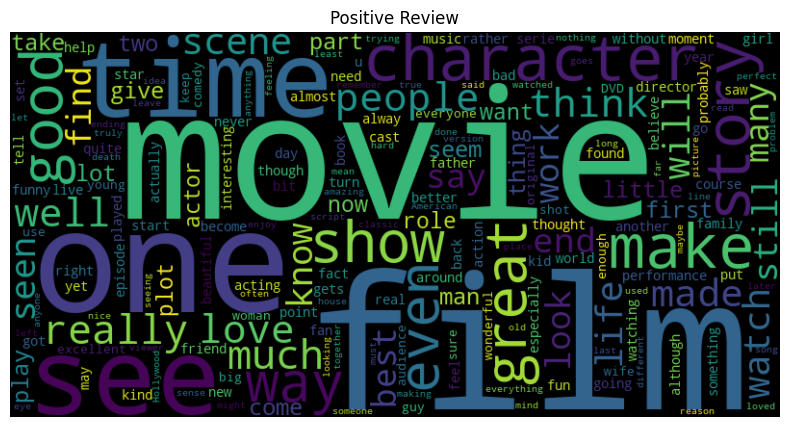

In [38]:
positive = train_df[train_df['sentiment']==1]['Cleaned_sentence'].tolist()
generate_wordcloud(positive,'Positive Review')

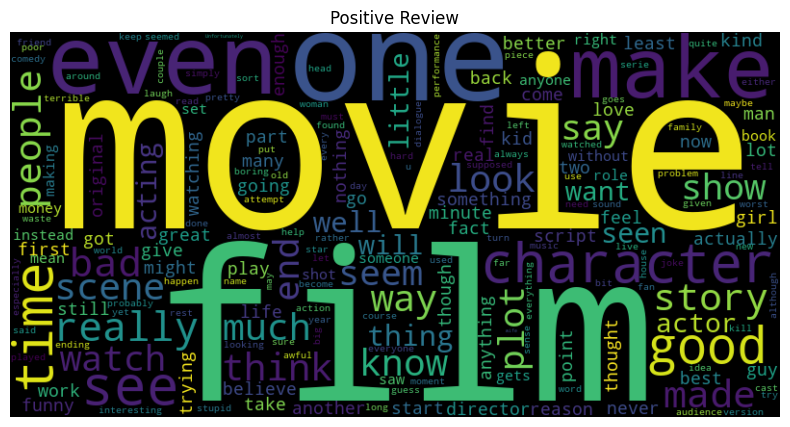

In [39]:
positive = train_df[train_df['sentiment']==0]['Cleaned_sentence'].tolist()
generate_wordcloud(positive,'Positive Review')

In [ ]:
Reviews = train_df['Cleaned_sentence']
Targets = train_df['sentiment']

test_reviews = test_df['Cleaned_sentence']
test_targets = test_df['sentiment']

In [ ]:
x_val, x_test, y_val, y_test = train_test_split(test_reviews,
                                                test_targets,
                                                test_size=0.5,
                                                stratify=test_targets)